In [1]:
import tensorflow as tf
import numpy as np

2024-10-09 17:05:04.671549: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-09 17:05:04.671981: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-09 17:05:04.674633: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-09 17:05:04.681840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-09 17:05:04.693915: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

## Prepare datasets

In [2]:
# load the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape((x_train.shape[0], 784))
x_test = x_test.reshape((x_test.shape[0], 784))

In [3]:
# initialize the pool of unlabeled data
pool_data = x_train[:1000]
pool_labels = tf.one_hot(y_train[:1000], depth=10)

In [4]:
# initialize the labeled data
labeled_data = x_train[1000:]
labeled_labels = tf.one_hot(y_train[1000:], depth=10)

In [5]:
labeled_data.shape, pool_data.shape

((59000, 784), (1000, 784))

## Create basic model

In [6]:
# define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_shape=(784,), activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/home/simon/git/neural_network_playground/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# train the model on the labeled data
model.fit(labeled_data, labeled_labels, epochs=10)

Epoch 1/10
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7253 - loss: 6.7425
Epoch 2/10
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8722 - loss: 0.5178
Epoch 3/10
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9092 - loss: 0.3596
Epoch 4/10
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9259 - loss: 0.2857
Epoch 5/10
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9336 - loss: 0.2579
Epoch 6/10
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9362 - loss: 0.2415
Epoch 7/10
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9405 - loss: 0.2231
Epoch 8/10
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9437 - loss: 0.2258
Epoch 9/10
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9465 - loss: 0.2026
Epoch 10/10
1844/1844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9467 - loss: 0.2082


## Processing with active learning loop

In [8]:
for i in range(3): #Number of iterations for active learning
    # Make prediction on unseen data and compute probabilities
    prediction = model.predict(pool_data)
    max_proba = tf.reduce_max(prediction, axis=1)


    # Extract the 100 first data from pool with the lowest probability
    indices = tf.argsort(max_proba, axis=-1)[:100]
    pool_data_lowest_prob = tf.gather(pool_data, indices)
    pool_data_lowest_prob = tf.cast(pool_data_lowest_prob, tf.int32)
    
    pool_labels_lowest_prob = tf.gather(pool_labels, indices)
    pool_labels_lowest_prob = tf.cast(pool_labels_lowest_prob, tf.float32)
    
    # Concatenate data with lowest probability with training data
    labeled_data = tf.concat([labeled_data, pool_data_lowest_prob], axis=0)
    labeled_labels = tf.concat([labeled_labels, pool_labels_lowest_prob], axis=0)

    # Remove data from pool that were added to train data
    pool_data = np.delete(pool_data, indices, axis=0)
    pool_labels = np.delete(pool_labels, indices, axis=0)

    print(f'labeled data size: {labeled_data.shape} - pool data size: {pool_data.shape}')
    model.fit(labeled_data, labeled_labels, epochs=3)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
labeled data size: (59100, 784) - pool data size: (900, 784)
Epoch 1/3
1847/1847 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9487 - loss: 0.1986
Epoch 2/3
1847/1847 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9516 - loss: 0.1871
Epoch 3/3
1847/1847 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9527 - loss: 0.1848
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
labeled data size: (59200, 784) - pool data size: (800, 784)
Epoch 1/3
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9539 - loss: 0.1825
Epoch 2/3
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9540 - loss: 0.1800
Epoch 3/3
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9565 - loss: 0.1717
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
labeled data size: (59300, 784) - pool data size: (700, 784)
Epoch 1/3
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9559 - loss: 0.1756
Epoch 2/3
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9549 - loss: 0.1714

## Checking relation between probabitity and entropy of classification
When the model is more confident about a prediction, the entropy of the probabilities should be lower. 
Let's check how the entropy behabes with respect to the probabilities and if it could be used as a metric in the discrimination used in the active
learning process.


In [9]:
from scipy.special import entr
import matplotlib.pyplot as plt

In [10]:
## Computing the entropy for each prediction 
pred_pool = model.predict(pool_data)
entropies = entr(pred_pool).sum(axis=1)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


In [11]:
# Preparaing entropy en proba to be plotted
# Note that we rely on the highest probability for each prediction, i.e., the value predicted. 
# The highest the probability, the most confident the model is -> The entropy should be lower.
proba, entropy_proba = [], []
for i, e in enumerate(entropies):
    proba.append(tf.reduce_max(pred_pool, axis=1)[i])
    entropy_proba.append(e)

Text(0, 0.5, 'Entropy')

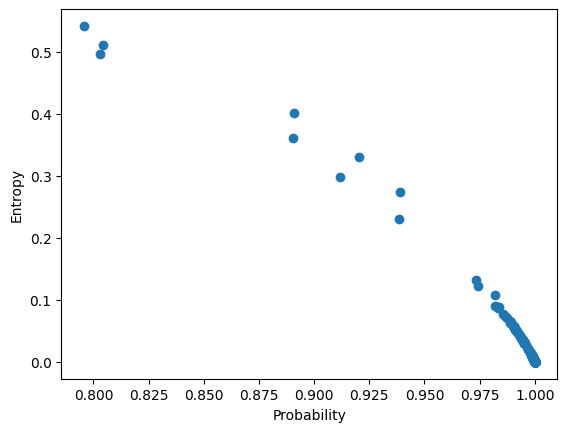

In [12]:
plt.scatter(proba, entropy_proba)
plt.xlabel('Probability')
plt.ylabel('Entropy')

The entropy seems to be strongly correlated to the entropy. It could also be used to estimate the less confident estimations to be used in the active learning process